In [1]:
from IPython.display import display, HTML
# from ipywidgets import interactive
import matplotlib.pyplot as plt
# import networkx as nx
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import sklearn.metrics
# import tensorflow as tf
# import tensorflow_probability as tfp
from tqdm.notebook import tqdm

from collections import namedtuple, defaultdict, Counter
from glob import glob
import itertools
import json
import os
import pickle
import re
import socket
import subprocess
import sys

plt.style.use('seaborn')
# tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
np.set_printoptions(suppress=True, precision=2, threshold=20)
pd.set_option('display.max_rows', 500)
sys.path += ['../src/']


In [2]:
sns.set_style("whitegrid")
sns.set_context('paper', font_scale=2.8)

In [3]:
def print_different_values(df_plot):
    fixed_fields2value = {}
    diff_fields = []
    values_of_diff_fields = []
    for field in df_plot.columns:
        if field.startswith('params.'):
            values = list(sorted(set(df_plot[~df_plot[field].isna()][field])))
            if len(values) > 1:
                diff_fields.append(field)
                values_of_diff_fields.append(values)
            elif len(values) == 1:
                fixed_fields2value[field] = values[0]
    
#     display(HTML('&nbsp; '.join([f"<b>{f}</b>: {v}." for f, v in fixed_fields2value.items()])))
    display(HTML("<h3>Fixed params</h3>"))
    display(pd.DataFrame.from_dict({f: [v] for f, v in fixed_fields2value.items()}))
    display(HTML("<h3>Changing params</h3>"))
    display(pd.DataFrame(index=diff_fields, data=values_of_diff_fields).fillna(''))

In [4]:
df = pd.read_csv("../data/axiomatic-benchmark-42.csv")
del df['params.kwargs_explainer']

In [5]:
df.columns

Index(['run_id', 'experiment_id', 'status', 'artifact_uri', 'start_time',
       'end_time', 'metrics.edge_quality_global', 'metrics.edge_quality_local',
       'metrics.feat_quality', 'metrics.edge_quality_weighted',
       'params.num_samples', 'params.frac_important_edge', 'params.gamma',
       'params.num_hops', 'params.frac_important_feat', 'params.seed',
       'params.dataset', 'params.dataset_id', 'params.measure_edges',
       'params.whitebox_type', 'params.explainer', 'params.epochs',
       'params.false_as_negatives', 'params.hop', 'params.num_nodes',
       'params.frac_positive_feat', 'params.num_features',
       'params.mean_degree', 'tags.mlflow.source.name',
       'tags.mlflow.source.git.commit', 'tags.mlflow.user',
       'tags.mlflow.source.type', 'tags.crashed'],
      dtype='object')

In [6]:

EDGE_FIDELITY_NAME = "Edge importance fidelity"
FEAT_FIDELITY_NAME = "Feature importance fidelity"
FRAC_POSITIVE_FEAT = "Fraction of positive features"
FRAC_IMPORTANT_FEAT = "Fraction of important features"
EXPLAINER = "Explainer"
MODEL = "Model"

In [8]:

def do_plot(real_dataset=False, false_as_negatives=False, x_axis=FRAC_POSITIVE_FEAT, y_axis=FEAT_FIDELITY_NAME, many_ticks=True):
    assert x_axis in {FRAC_IMPORTANT_FEAT, FRAC_POSITIVE_FEAT}
    display(HTML(f"<h1>real_dataset: {real_dataset}, false_as_negatives: {false_as_negatives}, x_axis: {x_axis}</h1>"))
    df_plot = df[
        (df["params.gamma"] == 1) &
        (df["params.false_as_negatives"] == false_as_negatives) &
        (df["params.frac_important_edge"] == 0.5) &
        ((df['params.dataset'] == 'FacebookDataset-1684') == real_dataset)
    ].sort_values(by=['params.whitebox_type', 'params.explainer'])
    if not real_dataset:
        if x_axis == FRAC_POSITIVE_FEAT:
            df_plot = df_plot[df_plot["params.frac_important_feat"] == 0.5]
        else:
            df_plot = df_plot[df_plot["params.frac_positive_feat"] == 0.5]
    print_different_values(df_plot)

    # sns.set(style="ticks", rc={"lines.linewidth": 0.7})

    df_plot = df_plot.rename(columns={
        "metrics.feat_quality": FEAT_FIDELITY_NAME,
        "metrics.edge_quality_local": EDGE_FIDELITY_NAME,
        "params.frac_important_feat": FRAC_IMPORTANT_FEAT,
        "params.frac_positive_feat": FRAC_POSITIVE_FEAT,
        "params.explainer": EXPLAINER,
        "params.whitebox_type": MODEL
    })
    df_plot[EXPLAINER] = (df_plot[EXPLAINER]
                                   .str.replace('_', ' ')
                                   .str.title()
                                   .str.replace('Gnn ', 'GNN ')
                                   .str.replace('Lrp', 'LRP')
                                  )
    df_plot[MODEL] = df_plot[MODEL].str.replace(' model', '')

    g = sns.catplot(
        data=df_plot,
        x=x_axis, y=y_axis,
        hue=EXPLAINER, col=MODEL,
        capsize=.2, errorbar=("pi", 100), scale=2.2, linestyles='', 
        kind="point", dodge=.2, aspect=1.4, lw=100, 
    )
    plt.ylim((0.45, 1.05))
    plt.yticks(np.linspace(0.5, 1, 6 if many_ticks else 3))
    assert df_plot[FEAT_FIDELITY_NAME].min() > 0.45
    sns.move_legend(g, "lower center",
                    bbox_to_anchor=(.45, -.1), ncol=5,
                    title=None, frameon=False)
#     plt.legend(bbox_to_anchor=(1.02, 0.15), loc='lower center', borderaxespad=0)
    path = (f"../paper/fig/{'real' if real_dataset else 'synth'}-{x_axis.split()[2]}" +
               ('-false_as_negatives' if false_as_negatives else ''))
    plt.savefig(path + '.pdf', bbox_inches='tight', )
    plt.savefig(path + '.png')

In [12]:
! mkdir -p ../paper/fig

,params.num_samples,params.frac_important_edge,params.gamma,params.num_hops,params.frac_important_feat,params.measure_edges,params.epochs,params.false_as_negatives,params.hop,params.num_nodes,params.num_features,params.mean_degree
0,100,0.5,1.0,2.0,0.5,True,1000.0,False,2.0,100.0,50.0,16.0


,0,1,2,3,4
params.seed,42,43,44,45,
params.dataset,ErdosRenyi-100-nodes-16-degree-50-features-10pos,ErdosRenyi-100-nodes-16-degree-50-features-30pos,ErdosRenyi-100-nodes-16-degree-50-features-50pos,ErdosRenyi-100-nodes-16-degree-50-features-70pos,ErdosRenyi-100-nodes-16-degree-50-features-90pos
params.whitebox_type,Local model,Neighborhood model,Two-hop model,,
params.explainer,deconvolution,gnn_explainer,graphlime,integrated_gradients,lrp
params.frac_positive_feat,0.1,0.3,0.5,0.7,0.9


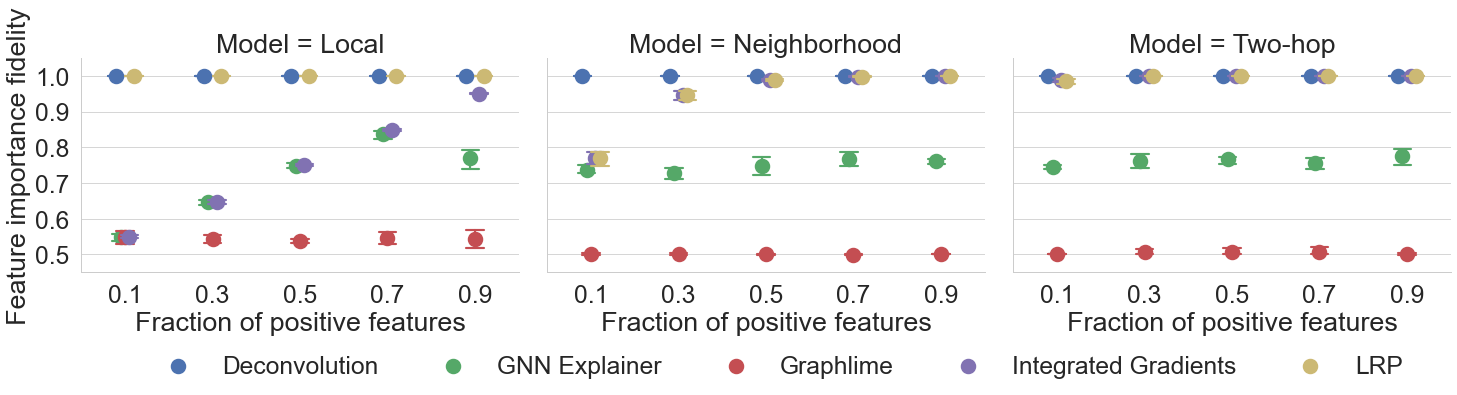

In [13]:
do_plot(x_axis=FRAC_POSITIVE_FEAT)

,params.num_samples,params.frac_important_edge,params.gamma,params.num_hops,params.dataset,params.measure_edges,params.epochs,params.false_as_negatives,params.hop,params.num_nodes,params.frac_positive_feat,params.num_features,params.mean_degree
0,100,0.5,1.0,2.0,ErdosRenyi-100-nodes-16-degree-50-features-50pos,True,1000.0,False,2.0,100.0,0.5,50.0,16.0


,0,1,2,3,4
params.frac_important_feat,0.1,0.2,0.3,0.4,0.5
params.seed,42,43,44,45,
params.whitebox_type,Local model,Neighborhood model,Two-hop model,,
params.explainer,deconvolution,gnn_explainer,graphlime,integrated_gradients,lrp


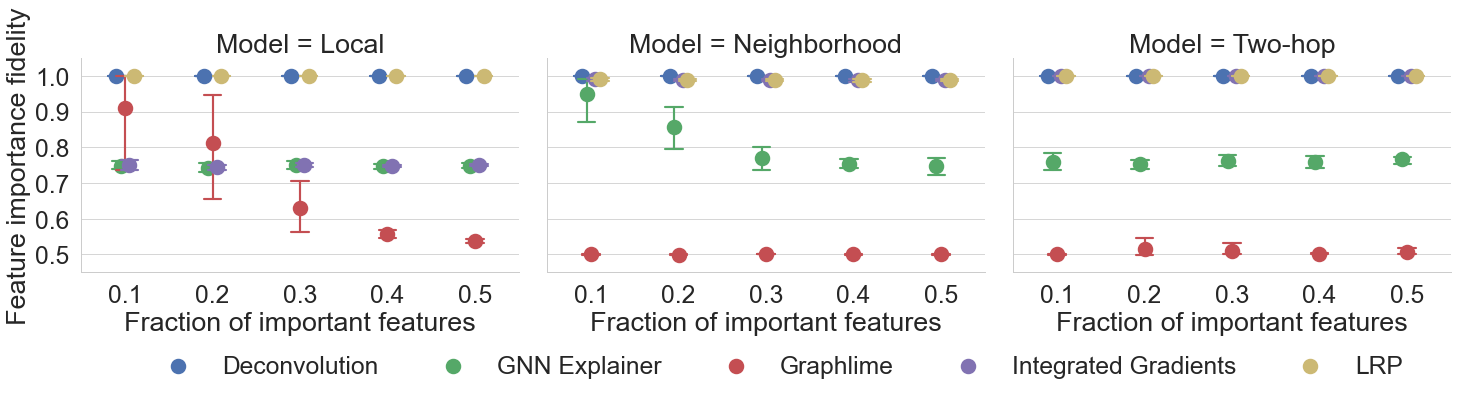

In [14]:
do_plot(x_axis=FRAC_IMPORTANT_FEAT)

,params.num_samples,params.frac_important_edge,params.gamma,params.num_hops,params.frac_important_feat,params.measure_edges,params.epochs,params.false_as_negatives,params.hop,params.num_nodes,params.num_features,params.mean_degree
0,100,0.5,1.0,2.0,0.5,True,1000.0,True,2.0,100.0,50.0,16.0


,0,1,2,3,4
params.seed,42,43,44,45,
params.dataset,ErdosRenyi-100-nodes-16-degree-50-features-10pos,ErdosRenyi-100-nodes-16-degree-50-features-30pos,ErdosRenyi-100-nodes-16-degree-50-features-50pos,ErdosRenyi-100-nodes-16-degree-50-features-70pos,ErdosRenyi-100-nodes-16-degree-50-features-90pos
params.whitebox_type,Local model,Neighborhood model,Two-hop model,,
params.explainer,deconvolution,gnn_explainer,graphlime,integrated_gradients,lrp
params.frac_positive_feat,0.1,0.3,0.5,0.7,0.9


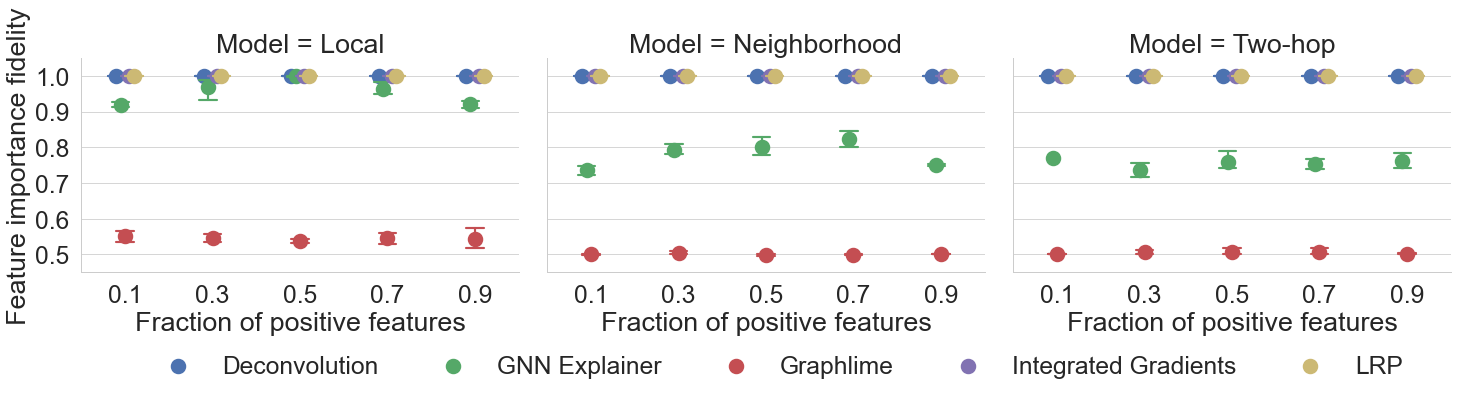

In [15]:
do_plot(false_as_negatives=True, x_axis=FRAC_POSITIVE_FEAT)

,params.num_samples,params.frac_important_edge,params.gamma,params.num_hops,params.dataset,params.measure_edges,params.epochs,params.false_as_negatives,params.hop,params.num_nodes,params.frac_positive_feat,params.num_features,params.mean_degree
0,100,0.5,1.0,2.0,ErdosRenyi-100-nodes-16-degree-50-features-50pos,True,1000.0,True,2.0,100.0,0.5,50.0,16.0


,0,1,2,3,4
params.frac_important_feat,0.1,0.2,0.3,0.4,0.5
params.seed,42,43,44,45,
params.whitebox_type,Local model,Neighborhood model,Two-hop model,,
params.explainer,deconvolution,gnn_explainer,graphlime,integrated_gradients,lrp


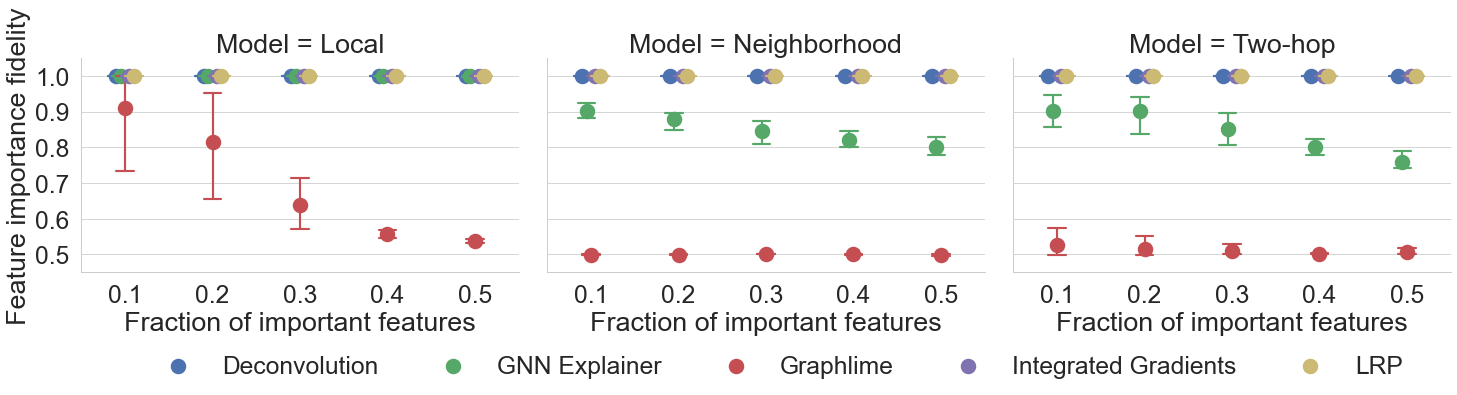

In [16]:
do_plot(false_as_negatives=True, x_axis=FRAC_IMPORTANT_FEAT)

,params.num_samples,params.frac_important_edge,params.gamma,params.num_hops,params.seed,params.dataset,params.dataset_id,params.measure_edges,params.epochs,params.false_as_negatives,params.hop
0,100,0.5,1.0,2.0,666,FacebookDataset-1684,1684.0,True,1000.0,False,2.0


,0,1,2,3,4
params.frac_important_feat,0.1,0.3,0.5,,
params.whitebox_type,Local model,Neighborhood model,Two-hop model,,
params.explainer,deconvolution,gnn_explainer,graphlime,integrated_gradients,lrp


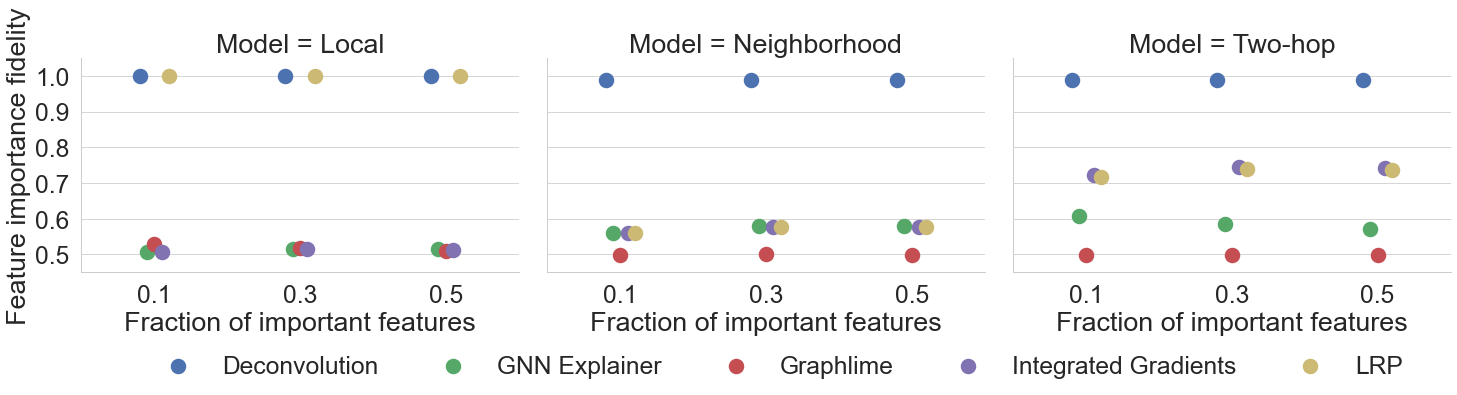

In [17]:
do_plot(real_dataset=True, x_axis=FRAC_IMPORTANT_FEAT)